<a href="https://colab.research.google.com/github/ifaul/ifaul.github.io/blob/main/lang_acquire_milestone2_11_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ian Faul, Matthew Vuong

**ESL to ETL: Investigating English proficiency of 2/3 million speakers**

[Link to our website](https://ifaul.github.io/)

[Link to CSV file in Drive](https://drive.google.com/file/d/1LJg6wTE_rl3WXP5lOFRoCuatc1WZjEQm/view?usp=share_link)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re

pd.options.mode.copy_on_write = True

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ColabNotebooks


In [3]:
#%%shell
#jupyter nbconvert --to html /content/drive/MyDrive/ColabNotebooks/lang_acquire_milestone1.ipynb

# **Project Goals**

How humans acquire new languages, and why some people are better at it than others, remains a remarkably mysterious question. While it is well-known that children are the most efficient language learners and that language-learning ability declines with age, the specific factors contributing to learning ability (age, gender, country of origin, native language, age at start of second language acquisition, etc.) are more complicated. Here, we plan on using a large dataset of close to 650,000 individuals to disentangle some of these factors and, hopefully, create a model that uses them to estimate language learning trajectory for English. In particular, we are curious to see whether there are any patterns in performance on particular questions across various groups, which would reveal both the underlying linguistic features being tested and those that are compartively more difficult to acquire. This was something not examined by the study associated with this dataset (Hartshorne, J.K. et al, 2018); while our intention isn't to directly replicate their findings, our secondary goal is to determine whether our results converge with their conclusions.

**Collaboration plan**

We (Ian Faul and Matthew Vuong) plan on meeting weekly to discuss the project's direction and implementation, assisting each other when necessary. We will also regularly update a document tracking which steps need to be completed and who they are to be completed by to ensure that work is fairly distributed. Lastly, we will establish a shared Github respository to store our code and our updates to it, allowing us to work remotely.

# **Milestone 1**
### **Some ETL**

We came across this dataset in the "Data Is Plural" archive and downloaded it from [OSF](https://osf.io/pyb8s/wiki/home/). We considered several similar datasets for this project, but this one stood out due to the large number of variables and observations, as well as its being associated with a study whose conclusions we could build on. The original dataset included the following variables:

**id** Unique subject ID

**date** Date at start of experiment

**time** Time at start of experiment

**gender**

**age**

**natlangs** List of subject's native languages

**primelangs** List of subject's primary language now

**dyslexia** Did subject report difficulty with reading?

**psychiatric** Did subject report any psychiatric disorders

**education** highest level of education

**Eng_start** age at start of English learning

**Eng_country_yrs** number of years living in English-speaking country

**house_Eng** subject lives with any native English speakers?

**dictionary** subject reported using a dictionary to complete experiment

**already_participated** Subject reported prior participation in experiment

**countries** countries lived in

**currcountry** country currently lived in

**US_region** regions of USA lived in

**UK_region** regions of UK lived in

**Can_region** regions of Canada lived in

**Ebonics** speaker of Ebonics?

**Ir_region** county of Ireland lived in

**UK_constituency** constituency of UK lived in

**nat_Eng** native speaker of English

**lived_Eng_per** Percentage of years speaking English that lived in English-speaking country.

**Eng_little** values are monoeng (native speaker of English only), bileng (native speaker of English + at least one other lang), lot (immersion learner), little (non-immersion learner).

**q1, q2, etc.** test questions, with subparts

**correct** percentage of critical items correct

**elogit** elogit of correct (not sure what this means)


While this data was originally collected for the primary purpose of finding the critical point in development where grammar-learning ability begins to decline (their finding: 17.4 years), some other specific questions this dataset allows us to consider are (1) Can the test questions be grouped into distinct types, other than the syntactic phenomena explicity included by the original researchers, based on systematic differences in performance among groups? (2) Are there systematic differences in the performance of speakers of native languages other than English? In other words, in which ways do speakers of some languages (or language groups) perform better or worse than others? (3) For people at or above the critical age found in the original study, which variables are associated with the highest overall performance or performance on specific questions/question types?

In the following section, we consider a more workable subset of 10,000 observations, removing variables likely of little relevance, creating new columns to more easily access information separated by commas in individual cells in the original data table, making values within columns consistent and of the correct data type, and lastly, tidying it up.

In [4]:
df_lang = pd.read_csv('data.csv', nrows=100001)
df_lang.head()

<ipython-input-4-a1f1fb77e63c>:1: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lang = pd.read_csv('data.csv', nrows=100001)


,Unnamed: 0,id,date,time,gender,age,natlangs,primelangs,dyslexia,psychiatric,...,q34_6,q34_8,q35_1,q35_2,q35_4,q35_5,q35_7,q35_8,correct,elogit
0,1,2.0,2014-05-29,01:00:55,male,31,English,English,0,0,...,1,1,1,1,1,1,1,1,0.978947,3.621671
1,2,3.0,2014-05-29,01:01:03,male,30,English,English,0,1,...,1,1,1,1,1,1,1,1,1.000000,5.252273
2,3,3.0,2014-05-29,01:01:03,male,30,English,English,0,1,...,1,1,1,1,1,1,1,1,1.000000,5.252273
3,4,4.0,2014-05-29,01:01:13,male,19,English,English,0,0,...,1,1,1,1,1,0,1,1,0.905263,2.208853
4,5,5.0,2014-05-29,01:01:19,male,20,"Chinese/Mandarin, English","Chinese/Mandarin, English",0,0,...,1,1,1,1,1,0,1,1,0.947368,2.800602


In [6]:
# Remove unnecessary variables

df_lang.drop(columns=['Unnamed: 0', 'date', 'time', 'US_region', 'UK_region',
                      'Can_region', 'Ir_region', 'UK_constituency', 'tests'], inplace=True)

# Strip whitespace in all columns

df_lang = df_lang.map(lambda x: x.strip() if isinstance(x, str) else x)

# Remove strange values in some variables

df_lang['education'].unique() # There are some crazy values in here!

def replace_school_with_NAN(entry, allowed_list):
    if entry not in allowed_list:
        return np.nan
    return entry

# These appear to be the original choices offered in the questionnaire.
allowed_list = ['Graduate Degree', 'Undergraduate Degree (3-5 years higher ed)',
                'Some Undergrad (higher ed)', 'High School Degree (12-13 years)',
                'Some Graduate School', 'Didn''t Finish High School (less than 13 years ed)']


df_lang['education'] = df_lang['education'].apply(lambda x: replace_school_with_NAN(x, allowed_list))

# Remove duplicates
df_lang.drop_duplicates(subset=['id'], inplace=True)

Now that we have cleaned up the dataframe a bit, we can confirm that all variables are of the correct data type and correct those that are not.

In [8]:
display(df_lang[['dyslexia', 'psychiatric', 'education', 'Eng_start', 'Eng_country_yrs',
         'house_Eng', 'dictionary', 'already_participated', 'countries', 'currcountry',
         'nat_Eng', 'prime_Eng', 'speaker_cat', 'Eng_little']].dtypes) # Checking to see which data types are incorrect

df_lang[['dyslexia', 'psychiatric','dictionary',
         'already_participated','nat_Eng', 'prime_Eng']] = df_lang[['dyslexia','psychiatric','dictionary', 'already_participated','nat_Eng', 'prime_Eng']].astype('bool')
display(df_lang[['dyslexia', 'psychiatric','dictionary', 'already_participated','nat_Eng', 'prime_Eng']].dtypes) # Converting appropriate colums to bools

# Select all question columns
questions = pd.Series(df_lang.columns).str.startswith('q')
question_cols = df_lang.columns[questions]

# Convert question columns to bools
df_lang[question_cols] = df_lang[question_cols].astype('bool')
display(df_lang[question_cols].dtypes)

,0
dyslexia,int64
psychiatric,int64
education,object
Eng_start,int64
Eng_country_yrs,float64
house_Eng,float64
dictionary,int64
already_participated,int64
countries,object
currcountry,object


,0
dyslexia,bool
psychiatric,bool
dictionary,bool
already_participated,bool
nat_Eng,bool
prime_Eng,bool


,0
q1,bool
q2,bool
q3,bool
q5,bool
q6,bool
...,...
q35_2,bool
q35_4,bool
q35_5,bool
q35_7,bool


Here, we split up the natlang and primelang variables...

In [9]:
# Tidying natlangs and primelangs

df_ref_natlang = pd.concat([df_lang['natlangs'].str.split(', ', expand=True),df_lang['id']],axis=1)
df_ref_natlang = pd.melt(df_ref_natlang,id_vars=['id'],value_vars=[0,1,2,3,4]).dropna() # This dropna does drop some observations because some people put no values for natlangs. not sure if we wanted them anyway
df_ref_natlang = df_ref_natlang.drop(columns=['variable']).set_index(['id']).sort_index()

df_ref_primelang = pd.concat([df_lang['primelangs'].str.split(', ', expand=True),df_lang['id']],axis=1)
df_ref_primelang = pd.melt(df_ref_primelang,id_vars=['id'],value_vars=[0,1,2,3,4,5,6,7]).dropna() # This dropna does drop some observations because some people put no values for natlangs. not sure if we wanted them anyway
df_ref_primelang = df_ref_primelang.drop(columns=['variable']).set_index(['id']).sort_index()

# Combine all forms of Chinese for simplicity (and future merging)
df_ref_natlang['value'] = df_ref_natlang['value'].str.replace(r'^Chinese.*', 'Chinese', regex=True)
df_ref_primelang['value'] = df_ref_primelang['value'].str.replace(r'^Chinese.*', 'Chinese', regex=True)

# Strip whitespace around language values
### MATTHEW: WE PROBABLY DON'T NEED THIS ANYMORE BUT CHECK BEFORE DELETING
df_ref_natlang['value'] = df_ref_natlang['value'].str.strip()
df_ref_primelang['value'] = df_ref_primelang['value'].str.strip()

df_linginfo_merged = pd.merge(df_ref_natlang, df_ref_primelang, on='id', how='outer').rename(columns={'value_x': 'natlang', 'value_y': 'primelang'})

In [10]:
df_lang_tidy = df_lang.drop(columns=['natlangs','primelangs'])
df_lang_tidy = df_lang_tidy.merge(df_linginfo_merged, on='id', how='outer')

In [11]:
# Find all values in natlang with the word chinese in them
df_lang_tidy.dropna(subset=['natlang'], inplace=True) # Drop rows with NaN values in 'natlang' column
df_lang_tidy[df_lang_tidy['natlang'].str.contains('Chinese')]['natlang'].unique()

array(['Chinese'], dtype=object)

The greatest challenge that we faced in the ETL section was splitting the natlang and primelang columns and adding them back to the dataframe before tidying it.

### **Some EDA**

Here, we give some summary statistics for native and primary languages.

In [44]:
# Number of native languages

df_lang_tidy['natlang'].value_counts()

,count
natlang,
English,53742
Finnish,32930
Chinese,10782
German,6066
Swedish,5093
...,...
Zarma,1
Cispa,1
Fang,1


In [45]:
# Number of primary languages

df_lang_tidy['primelang'].value_counts()

,count
primelang,
English,77724
Finnish,22316
Chinese,6751
German,6235
Swedish,5121
...,...
Bicol,1
Karelian,1
Manx,1


,age
count,99999.000000
mean,29.089601
std,10.527055
min,7.000000
25%,22.000000
50%,26.000000
75%,34.000000
max,89.000000


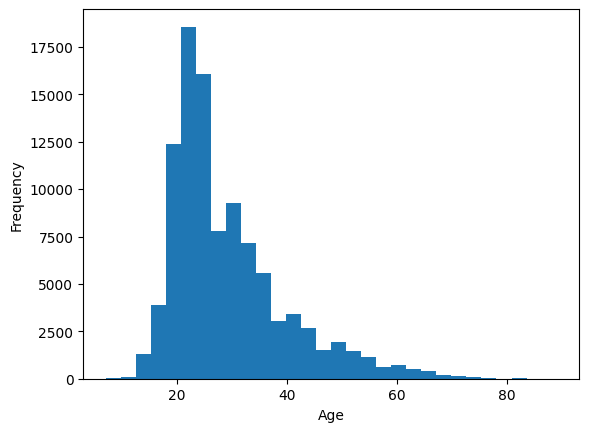

In [13]:
# Histogram of age of participants

df_lang['age'].plot.hist(xlabel='Age', bins=30)
df_lang['age'].describe()

,Eng_start
count,55079.000000
mean,8.620527
std,3.698787
min,0.000000
25%,7.000000
50%,9.000000
75%,10.000000
max,69.000000


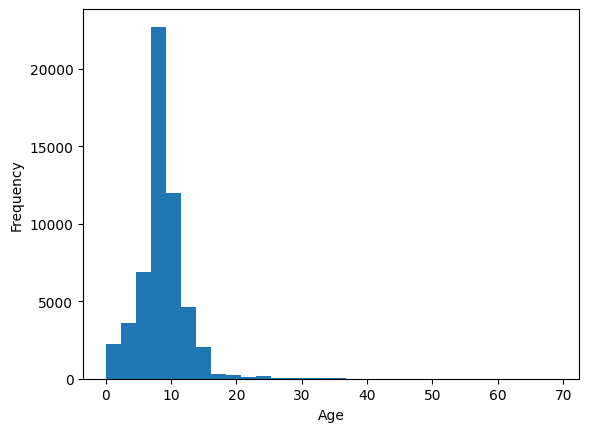

In [14]:
# Histogram of first English exposure for non-native speakers

df_lang_nonnat = df_lang[df_lang['nat_Eng'] == 0]
df_lang_nonnat['Eng_start'].plot.hist(bins=30, xlabel='Age')
df_lang_nonnat['Eng_start'].describe()

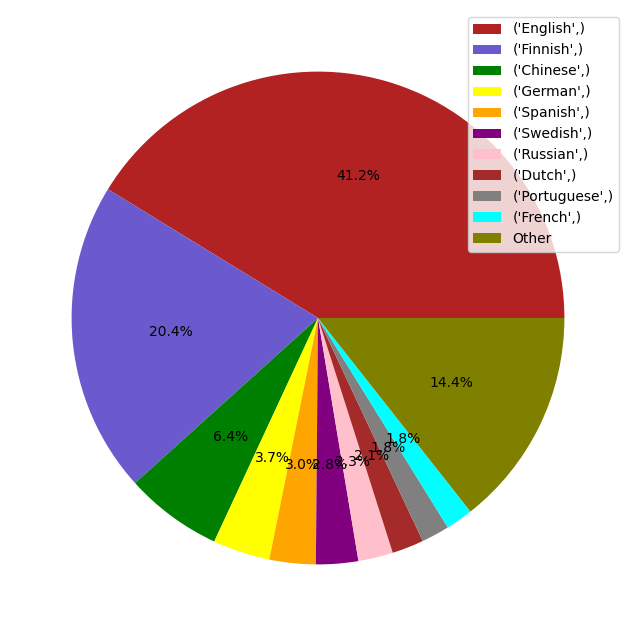

In [15]:
# Pie chart showing the percentages of non-native English speakers in the dataset

df_natlang_other = pd.Series(df_ref_natlang.value_counts().iloc[10:].sum(), index=['Other'])
df_natlang_pie = pd.concat([df_ref_natlang.value_counts().iloc[0:10], df_natlang_other])

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['firebrick', 'slateblue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan', 'olive']

ax.pie(x=df_natlang_pie.values, labels=None, colors=colors, autopct='%1.1f%%')
plt.legend(df_natlang_pie.index, loc='best')
plt.show()

,0
q34_4,0.766268
q33_5,0.784528
q25_2,0.798538
q11_4,0.809168
q2,0.809278
...,...
q13_4,0.999340
q26_3,0.999350
q10_4,0.999390
q10_2,0.999470


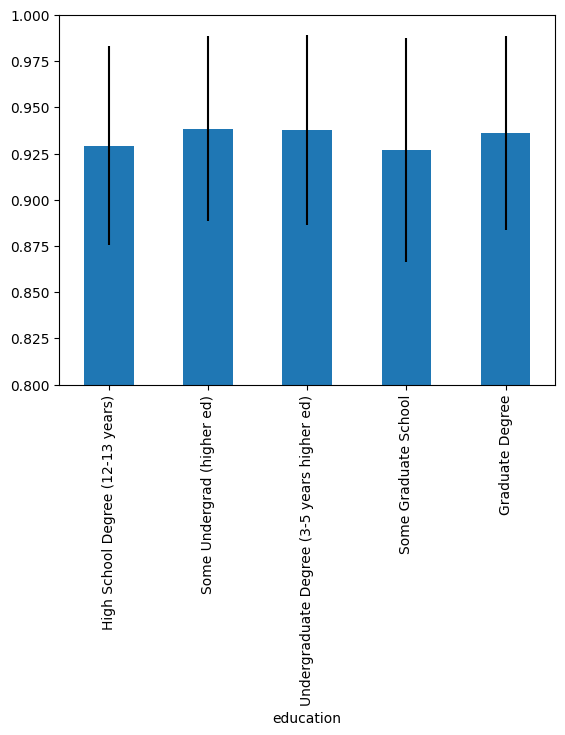

In [16]:
# Investigating whether level of education affects proficiency scores
### WE COULD CUT THIS

df_lang_nonnat[['education','correct']].groupby('education').mean().reindex([
    'High School Degree (12-13 years)',
    'Some Undergrad (higher ed)',
    'Undergraduate Degree (3-5 years higher ed)',
    'Some Graduate School',
    'Graduate Degree']).plot.bar(ylim=[0.8,1],yerr=df_lang_nonnat[['education','correct']].groupby('education').std(), legend=None)

# What about specific questions? What are the most missed questions?
df_testinfo = df_lang[question_cols]
df_testinfo = df_testinfo.assign(correct=df_lang['correct'], elogit=df_lang['elogit'])

df_testinfo.mean().sort_values() # 34_4, 2, 33_5 are top 3 most missed (still over 75% though)

<Axes: xlabel='education'>

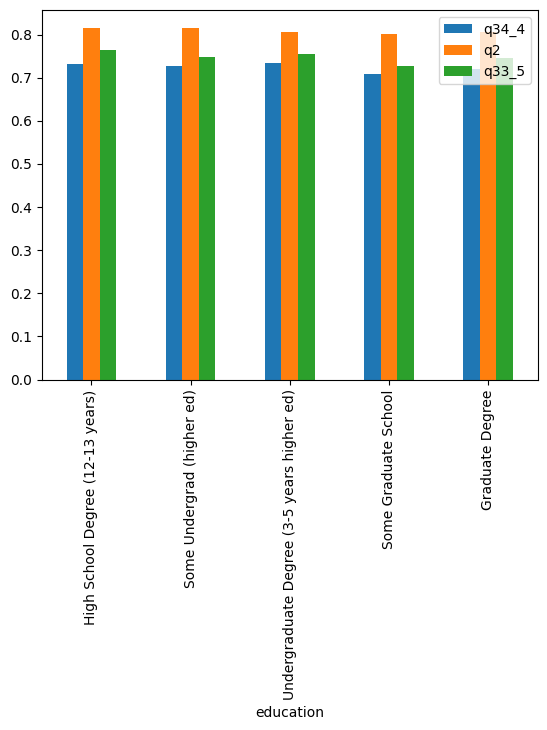

In [17]:
# Investigating whether education level affects the most missed questions
### WE COULD CUT THIS

df_lang_nonnat[['education','q34_4','q2','q33_5']].groupby('education').mean().reindex([
    'High School Degree (12-13 years)',
    'Some Undergrad (higher ed)',
    'Undergraduate Degree (3-5 years higher ed)',
    'Some Graduate School',
    'Graduate Degree']).plot.bar()

# The answer: not really

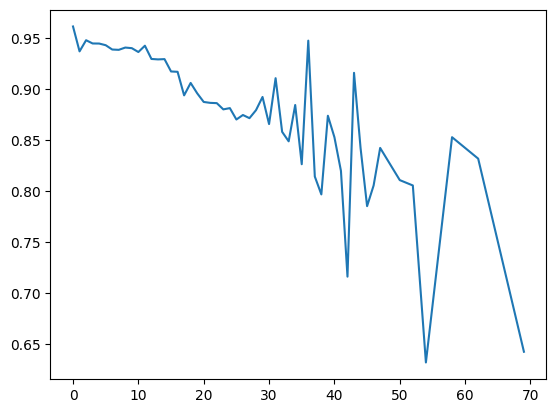

In [18]:
#test1 = df_lang_tidy.groupby(['Eng_start'])['elogit'].mean()
test2 = df_lang_tidy.groupby(['Eng_start'])['correct'].mean()
#df_lang_tidy['natlang_family'].value_counts()

#fig1 = plt.figure()
#ax1 = fig1.add_subplot(111)
#ax1.plot(test1)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(test2)

<Axes: xlabel='Eng_start', ylabel='Eng_country_yrs'>

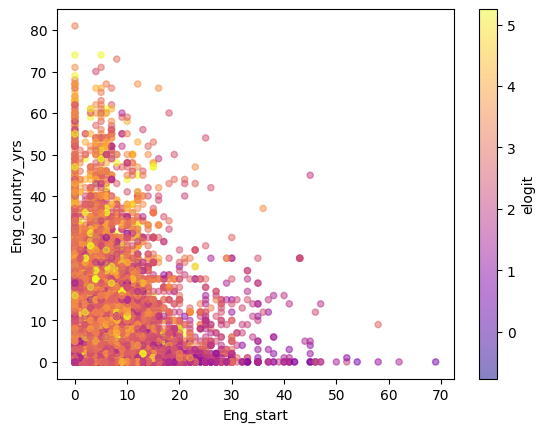

In [19]:
df_lang_tidy.plot.scatter(x='Eng_start',y='Eng_country_yrs',c='elogit',cmap='plasma',alpha=0.5)

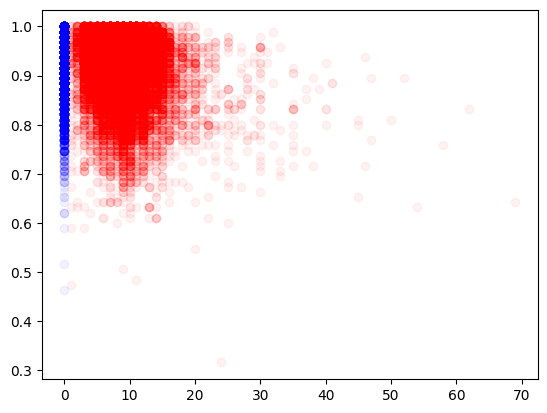

In [20]:
test2 = df_lang_tidy[df_lang_tidy['Eng_little'] == 'little'].groupby(['Eng_start'])['correct'].mean()

test3 = df_lang_tidy[df_lang_tidy['Eng_little'] == 'little']#[df_lang_tidy['Eng_start'] >= 17]
test4 = df_lang_tidy[df_lang_tidy['Eng_little'] == 'monoeng']

plt.scatter(test3['Eng_start'],test3['correct'], c='red',alpha=0.05)
plt.scatter(test4['Eng_start'],test4['correct'], c='blue',alpha=0.05)

### Conclusion

From these light analyses, we have a better understanding of the demographics of the participants included, and we began to show what relationships might exist between demographic characteristics and English proficiency. We are interested in grouping by native language along with other variables to see if patterns emerge in the scores and types of questions.

# Milestone 2

In this section, we will explore whether English proficiency varies depending on not just native language, but native language family. We may also choose to investigate whether certain syntactic features present in the native language but not in English (or vice versa) affect performance on particular questions.

In [21]:
# Change to folder containing all additional CSVs:
%cd /content/drive/MyDrive/ColabNotebooks/additionalFiles

import glob

# Glob all csv files
all_csvs = glob.glob('*.csv')

# Create base df for later merging:
df_features = pd.read_csv('future_tense.csv',sep='\t').drop(columns = ['description','value'])

# Iterate through list and merge dfs:
for file in all_csvs:
  # Read in current file and slice for non-redundant columns:
  df_current = pd.read_csv(file,sep='\t')
  df_current = df_current[['name','value','description']]
  current_name = file[:-4] # Get name of file for df columns

  df_current = df_current.rename(columns={'name':'name','value':current_name+'_value','description':current_name+'_description'})
  df_features = df_features.merge(df_current, on='name',how='outer')

# Drop unnecessary variables
df_features.drop(columns=['wals code', 'latitude', 'longitude', 'area'])

/content/drive/MyDrive/ColabNotebooks/additionalFiles


,name,genus,family,case_num_value,case_num_description,perfective_aspect_value,perfective_aspect_description,future_tense_value,future_tense_description,indef_art_value,indef_art_description,def_article_value,def_article_description,lang_order_value,lang_order_description,past_tense_value,past_tense_description
0,!Xóõ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,SVO,NaN,NaN
1,//Ani,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,No dominant order,NaN,NaN
2,/Xam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,SVO,NaN,NaN
3,=|Hoan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,SVO,NaN,NaN
4,Aari,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,"No indefinite, but definite article",3.0,Definite affix,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,Zoque (Ostuacan),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,No dominant order,NaN,NaN
1473,Zulu,Bantu,Niger-Congo,1.0,No morphological case-marking,1.0,Grammatical marking,1.0,Inflectional future exists,5.0,No definite or indefinite article,5.0,No definite or indefinite article,2.0,SVO,2.0,"Present, 2-3 remoteness distinctions"
1474,Zuni,Zuni,Zuni,1.0,No morphological case-marking,2.0,No grammatical marking,2.0,No inflectional future,NaN,NaN,NaN,NaN,1.0,SOV,1.0,"Present, no remoteness distinctions"
1475,rGyalrong (Caodeng),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,SOV,NaN,NaN


In [22]:
# Check for differences between Mandarin and Cantonese
mandarin = df_features[df_features['name'] == 'Mandarin'].reset_index(drop=True)
cantonese = df_features[df_features['name'] == 'Cantonese'].reset_index(drop=True)
mandarin.compare(cantonese)

# Combine Mandarin and Cantonese into a single observation, Chinese
df_features.loc[df_features['name'] == 'Mandarin', 'name'] = 'Chinese'
df_features.loc[df_features['name'] == 'Cantonese', 'name'] = 'Chinese'
df_features = df_features.groupby('name').first().reset_index()

# Check
df_features[df_features['name'] == 'Chinese']

,name,wals code,latitude,longitude,genus,family,area,case_num_value,case_num_description,perfective_aspect_value,...,future_tense_value,future_tense_description,indef_art_value,indef_art_description,def_article_value,def_article_description,lang_order_value,lang_order_description,past_tense_value,past_tense_description
258,Chinese,cnt,23.0,113.0,Chinese,Sino-Tibetan,Verbal Categories,1.0,No morphological case-marking,1.0,...,2.0,No inflectional future,2.0,Indefinite word same as 'one',4.0,"No definite, but indefinite article",2.0,SVO,4.0,No past tense


In [23]:
# Merge df_features with df_lang_tidy on natlang
df_features = df_features.rename(columns={'name':'natlang'})
df_lang_tidy = df_lang_tidy.merge(df_features, how='left', on='natlang')

In the section below, we explore the distributions of some of the syntactic features of people's native languages.

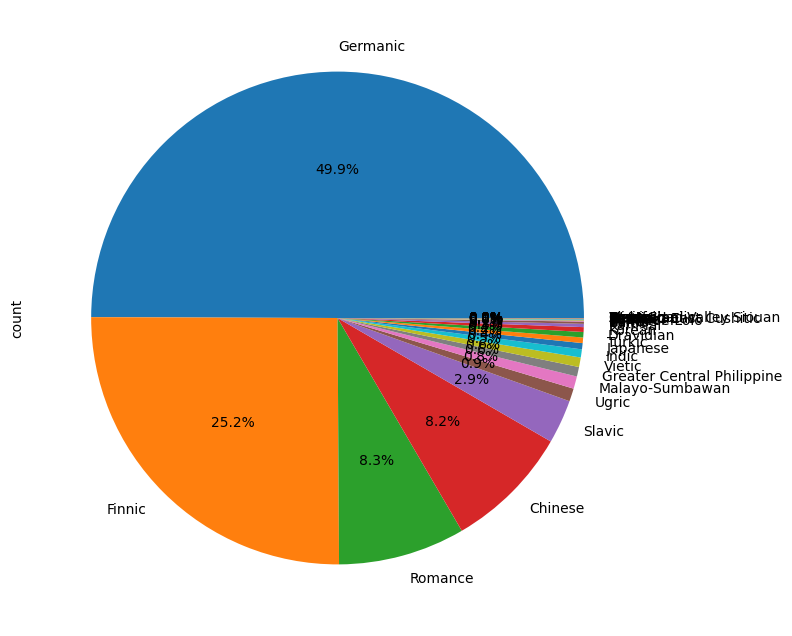

In [24]:
genus_pie = df_lang_tidy['genus'].value_counts().plot.pie(figsize=(8,8), autopct='%1.1f%%')

What are the distributions of particular languages within each language family represented here?

In [25]:
for genus in df_lang_tidy['genus'].unique():
  display(genus)
  display(df_lang_tidy[df_lang_tidy['genus'] == genus]['natlang'].value_counts())

'Germanic'

,count
natlang,
English,53742
German,6066
Swedish,5093
Afrikaans,256
Icelandic,239


'Chinese'

,count
natlang,
Chinese,10782


'Greater Central Philippine'

,count
natlang,
Tagalog,786
Cebuano,37


'Vietic'

,count
natlang,
Vietnamese,817


'Romance'

,count
natlang,
Spanish,4950
French,2959
Portuguese,2457
Romanian,522


None

,count
natlang,


'Indic'

,count
natlang,
Hindi,440
Bengali,257


'Japanese'

,count
natlang,
Japanese,532


'Slavic'

,count
natlang,
Russian,3441
Bulgarian,319


nan

,count
natlang,


'Finnic'

,count
natlang,
Finnish,32930


'Turkic'

,count
natlang,
Turkish,475


'Ugric'

,count
natlang,
Hungarian,1114


'Dravidian'

,count
natlang,
Tamil,378
Kannada,89


'Baltic'

,count
natlang,
Latvian,190


'Korean'

,count
natlang,
Korean,412


'Defoid'

,count
natlang,
Yoruba,20


'Kam-Tai'

,count
natlang,
Thai,268
Lao,11


'Lowland East Cushitic'

,count
natlang,
Somali,24


'Semitic'

,count
natlang,
Maltese,46


'Burmese-Lolo'

,count
natlang,
Burmese,47


'Malayo-Sumbawan'

,count
natlang,
Indonesian,1065


'Basque'

,count
natlang,
Basque,45


'Bantu'

,count
natlang,
Swahili,40
Zulu,8


'Ainu'

,count
natlang,
Ainu,10


'Khmer'

,count
natlang,
Khmer,23


'Kartvelian'

,count
natlang,
Georgian,24


'Oceanic'

,count
natlang,
Maori,7
Hawaiian,2


'Wolof'

,count
natlang,
Wolof,2


'Barito'

,count
natlang,
Malagasy,2


'West Chadic'

,count
natlang,
Hausa,1


'Mississippi Valley Siouan'

,count
natlang,
Lakhota,5


Let's explore some of the variation in syntactic features.

lang_order_description  natlang   
No dominant order       German        6066
                        Dutch         3643
                        Hungarian     1114
                        Frisian         56
                        Cherokee        12
                                      ... 
VSO                     Welsh          133
                        Cebuano         37
                        Hiligaynon       9
                        Maori            7
                        Hawaiian         2
Name: count, Length: 80, dtype: int64

<Axes: title={'center': 'Distribution of word order'}, xlabel='lang_order_description'>

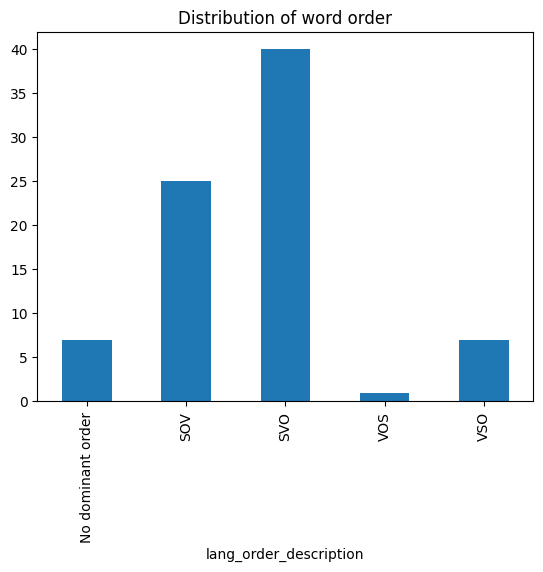

In [26]:
display(df_lang_tidy.groupby('lang_order_description')['natlang'].value_counts())
df_lang_tidy.groupby('lang_order_description')['natlang'].nunique().plot.bar(title='Distribution of word order') # Plot shows distribution of different word orders among languages

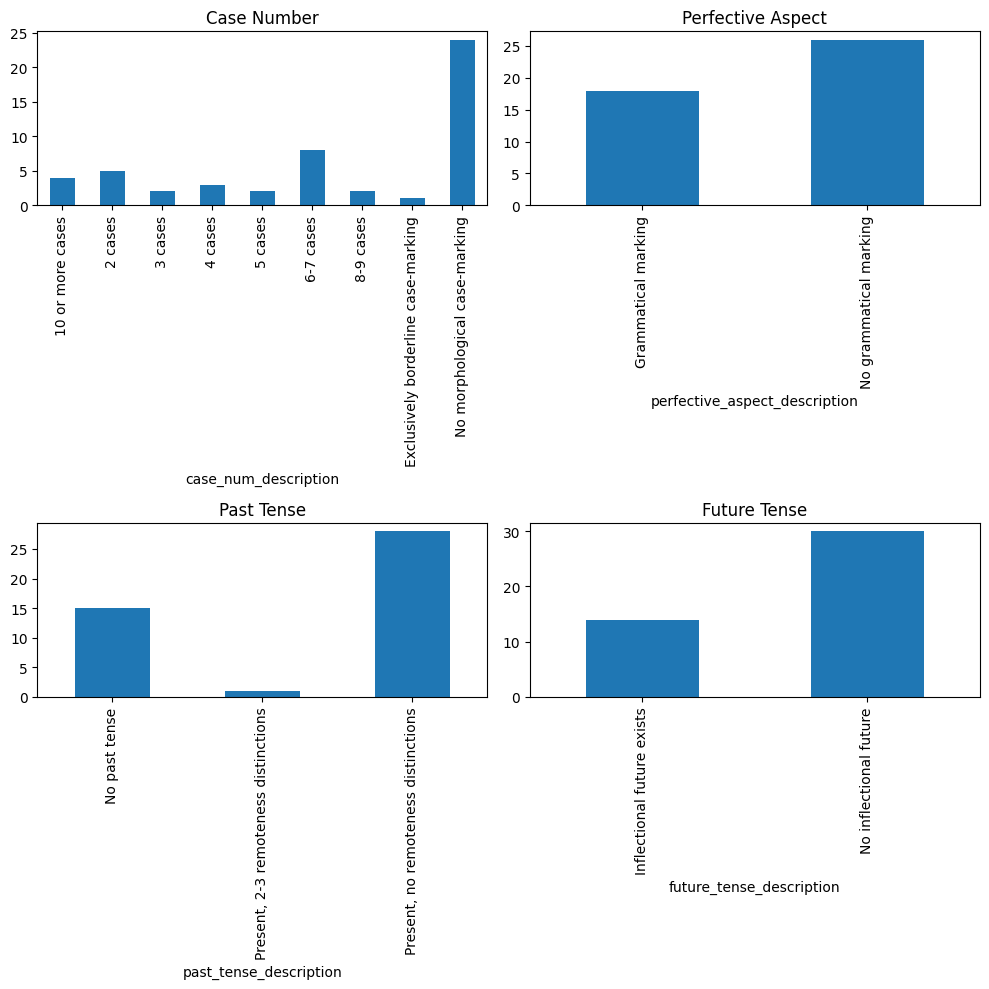

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

ax1 = axs[0,0]
df_lang_tidy.groupby('case_num_description')['natlang'].nunique().plot(kind='bar', ax=ax1)
ax1.set_title('Case Number')

ax2 = axs[0,1]
df_lang_tidy.groupby('perfective_aspect_description')['natlang'].nunique().plot(kind='bar', ax=ax2)
ax2.set_title('Perfective Aspect')

ax3 = axs[1,0]
df_lang_tidy.groupby('past_tense_description')['natlang'].nunique().plot(kind='bar', ax=ax3)
ax3.set_title('Past Tense')

ax4 = axs[1,1]
df_lang_tidy.groupby('future_tense_description')['natlang'].nunique().plot(kind='bar', ax=ax4)
ax4.set_title('Future Tense')

plt.tight_layout()
plt.show()

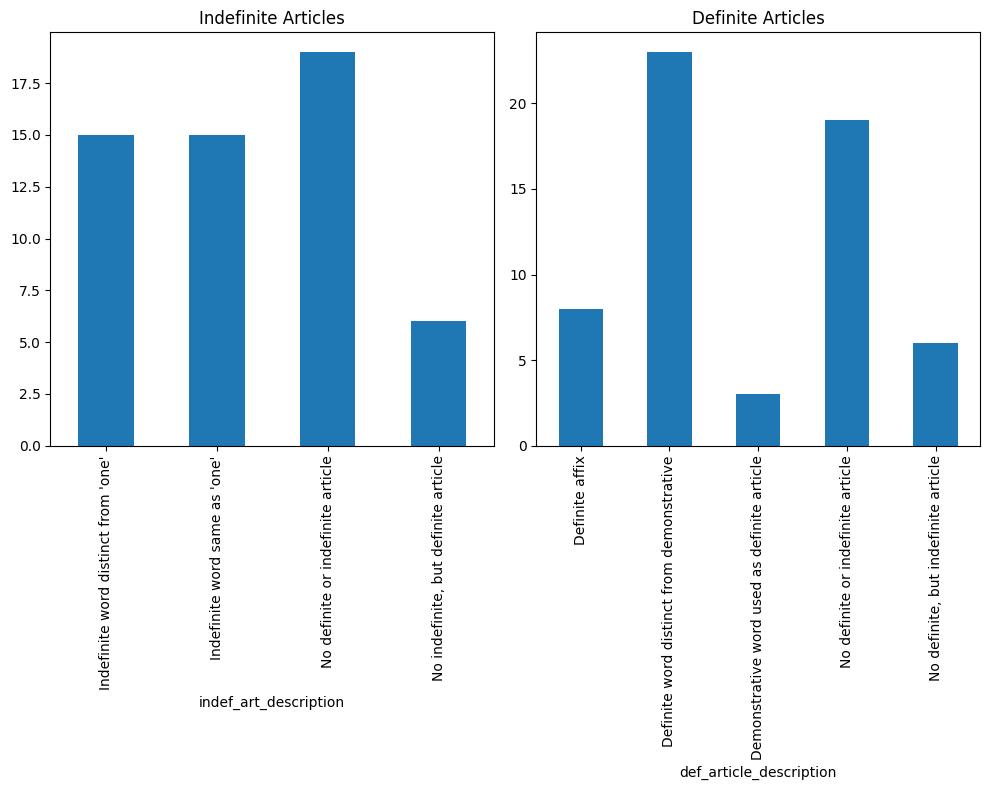

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

ax1 = axs[0]
df_lang_tidy.groupby('indef_art_description')['natlang'].nunique().plot(kind='bar', ax=ax1)
ax1.set_title('Indefinite Articles')

ax2 = axs[1]
df_lang_tidy.groupby('def_article_description')['natlang'].nunique().plot(kind='bar', ax=ax2)
ax2.set_title('Definite Articles')

plt.tight_layout()
plt.show()

We could also look into which languages possess each of these features, as well as how common speaking a language with each of these features is within the dataset. However, since our goal for the next step of the project is to group languages by how grammatically similar they are (regardless of language family, speaker similarity, or other variables) and then determine whether certain groups perform better than others on the English proficiency test, the distribution of these syntactic features across languages is more relevant here.

Now that we have a better idea about the distribution of these syntactic features across languages in the dataset, let's sort the languages by their distance from English based on these features.

In [31]:
df_features

,natlang,wals code,latitude,longitude,genus,family,area,case_num_value,case_num_description,perfective_aspect_value,...,future_tense_value,future_tense_description,indef_art_value,indef_art_description,def_article_value,def_article_description,lang_order_value,lang_order_description,past_tense_value,past_tense_description
0,!Xóõ,None,NaN,NaN,None,None,None,NaN,None,NaN,...,NaN,None,NaN,None,NaN,None,2.0,SVO,NaN,None
1,//Ani,None,NaN,NaN,None,None,None,NaN,None,NaN,...,NaN,None,NaN,None,NaN,None,7.0,No dominant order,NaN,None
2,/Xam,None,NaN,NaN,None,None,None,NaN,None,NaN,...,NaN,None,NaN,None,NaN,None,2.0,SVO,NaN,None
3,=|Hoan,None,NaN,NaN,None,None,None,NaN,None,NaN,...,NaN,None,NaN,None,NaN,None,2.0,SVO,NaN,None
4,Aari,None,NaN,NaN,None,None,None,NaN,None,NaN,...,NaN,None,4.0,"No indefinite, but definite article",3.0,Definite affix,NaN,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,Zoque (Ostuacan),None,NaN,NaN,None,None,None,NaN,None,NaN,...,NaN,None,NaN,None,NaN,None,7.0,No dominant order,NaN,None
1472,Zulu,zul,-30.000000,30.000000,Bantu,Niger-Congo,Verbal Categories,1.0,No morphological case-marking,1.0,...,1.0,Inflectional future exists,5.0,No definite or indefinite article,5.0,No definite or indefinite article,2.0,SVO,2.0,"Present, 2-3 remoteness distinctions"
1473,Zuni,zun,35.083333,-108.833333,Zuni,Zuni,Verbal Categories,1.0,No morphological case-marking,2.0,...,2.0,No inflectional future,NaN,None,NaN,None,1.0,SOV,1.0,"Present, no remoteness distinctions"
1474,rGyalrong (Caodeng),None,NaN,NaN,None,None,None,NaN,None,NaN,...,NaN,None,NaN,None,NaN,None,1.0,SOV,NaN,None


In [38]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

df_lang_tidy_20 = df_lang_tidy['natlang'].value_counts()[:20].index

# Find distances between languages based on syntactic features
df_features = df_features[df_features['natlang'].isin(df_lang_tidy_20)]
df_features_quant = df_features[['lang_order_value', 'case_num_value',
                                  'perfective_aspect_value', 'past_tense_value', 'future_tense_value',
                                  'indef_art_value', 'def_article_value']].fillna(0)

# Standardize data
#scaler = StandardScaler()
#scaler.fit(df_features_quant)
#df_features_sc = scaler.transform(df_features_quant)

D = pairwise_distances(df_features_quant, metric='euclidean')
np.fill_diagonal(D, np.nan)
df_features_quant = pd.DataFrame(D, index=df_features['natlang'], columns=df_features['natlang'])
display(df_features_quant)

natlang,Chinese,Danish,Dutch,English,Finnish,French,German,Hungarian,Indonesian,Italian,Norwegian,Polish,Portuguese,Russian,Spanish,Swedish,Tagalog,Vietnamese
natlang,,,,,,,,,,,,,,,,,,
Chinese,NaN,4.898979,7.483315,4.582576,8.306624,4.358899,7.280110,9.695360,3.000000,5.477226,4.795832,7.483315,4.358899,6.633250,4.358899,3.464102,4.690416,3.741657
Danish,4.898979,NaN,5.477226,4.123106,9.643651,3.000000,7.416198,10.099505,5.916080,2.449490,1.000000,7.483315,3.316625,7.874008,3.000000,3.741657,5.477226,5.477226
Dutch,7.483315,5.477226,NaN,5.916080,10.723805,5.385165,4.358899,7.615773,7.681146,5.099020,5.567764,9.055385,5.744563,9.380832,5.385165,6.324555,6.000000,7.071068
English,4.582576,4.123106,5.916080,NaN,8.246211,2.000000,5.477226,7.810250,4.472136,3.316625,4.242641,7.549834,2.449490,7.000000,2.000000,2.236068,3.872983,3.316625
Finnish,8.306624,9.643651,10.723805,8.246211,NaN,8.717798,8.124038,7.549834,8.246211,9.110434,9.273618,3.605551,9.486833,2.236068,8.717798,7.000000,10.535654,9.949874
French,4.358899,3.000000,5.385165,2.000000,8.717798,NaN,6.000000,8.774964,4.000000,1.732051,2.828427,7.280110,1.414214,7.141428,0.000000,2.645751,3.872983,3.872983
German,7.280110,7.416198,4.358899,5.477226,8.124038,6.000000,NaN,4.123106,6.928203,6.557439,7.348469,7.937254,6.480741,7.416198,6.000000,5.744563,6.403124,6.855655
Hungarian,9.695360,10.099505,7.615773,7.810250,7.549834,8.774964,4.123106,NaN,9.643651,9.165151,10.148892,8.366600,9.539392,7.874008,8.774964,8.124038,8.831761,9.165151
Indonesian,3.000000,5.916080,7.681146,4.472136,8.246211,4.000000,6.928203,9.643651,NaN,5.385165,5.477226,7.681146,4.000000,6.708204,4.000000,3.872983,4.795832,4.123106


In [39]:
df_features_quant.idxmin(axis=1)

,0
natlang,
Chinese,Indonesian
Danish,Norwegian
Dutch,German
English,French
Finnish,Russian
French,Spanish
German,Hungarian
Hungarian,German
Indonesian,Chinese


<Axes: xlabel='natlang', ylabel='natlang'>

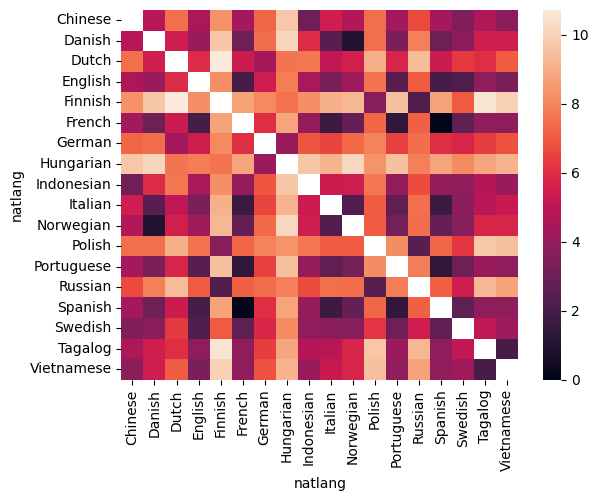

In [42]:
# create a visualization for the distance matrix
import seaborn as sns
sns.heatmap(df_features_quant)